In [44]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
import warnings
import itertools
from sklearn import linear_model

%pylab inline

Populating the interactive namespace from numpy and matplotlib


c:\users\dell\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Полезные функции

In [45]:
# получение данных о поездках из региона по данным с заданными временными рамками.
# формат данных- таблица время\регион: число поездок
def read_region_from_data(dataDir, region, start_year, start_month, last_year, last_month, max_iterations = 50):
    month = start_month
    year = start_year

    df = pd.DataFrame()
    iter = 0
    while iter < max_iterations:  
        month_data = pd.read_csv(dataDir + '/trip_count_%d-%02d.csv' % (year, month))
        month_data.set_index(['Unnamed: 0'], inplace=True)
        
        strReg = str(region)
        df = pd.concat((df,month_data[strReg]), axis = 0)

        # Return on last month and year
        if (month == last_month and year == last_year):
            df.index.name = 'time'
            df.index = pd.to_datetime(df.index)
            df.columns = [strReg + '_count']
            return df

        # Increment month
        if (month == 12):
            month = 1
            year += 1
        else:
            month += 1
        
        iter += 1           

In [46]:
# Из-за аномалий (нулевых) для Бокса-Кокса введён сдвиг,
def inverse_shifted_boxcox(y, lmda, shift=10):
    return np.exp(y) - shift if lmda == 0 else (np.exp(np.log(lmda * y + 1) / lmda)) - shift

def shifted_boxcox(y, shift=10):
    return stats.boxcox(y + shift)   

Чтение данных по отдельному региону

In [47]:
data = read_region_from_data('trips', 1231, 2016, 1, 2016, 5)

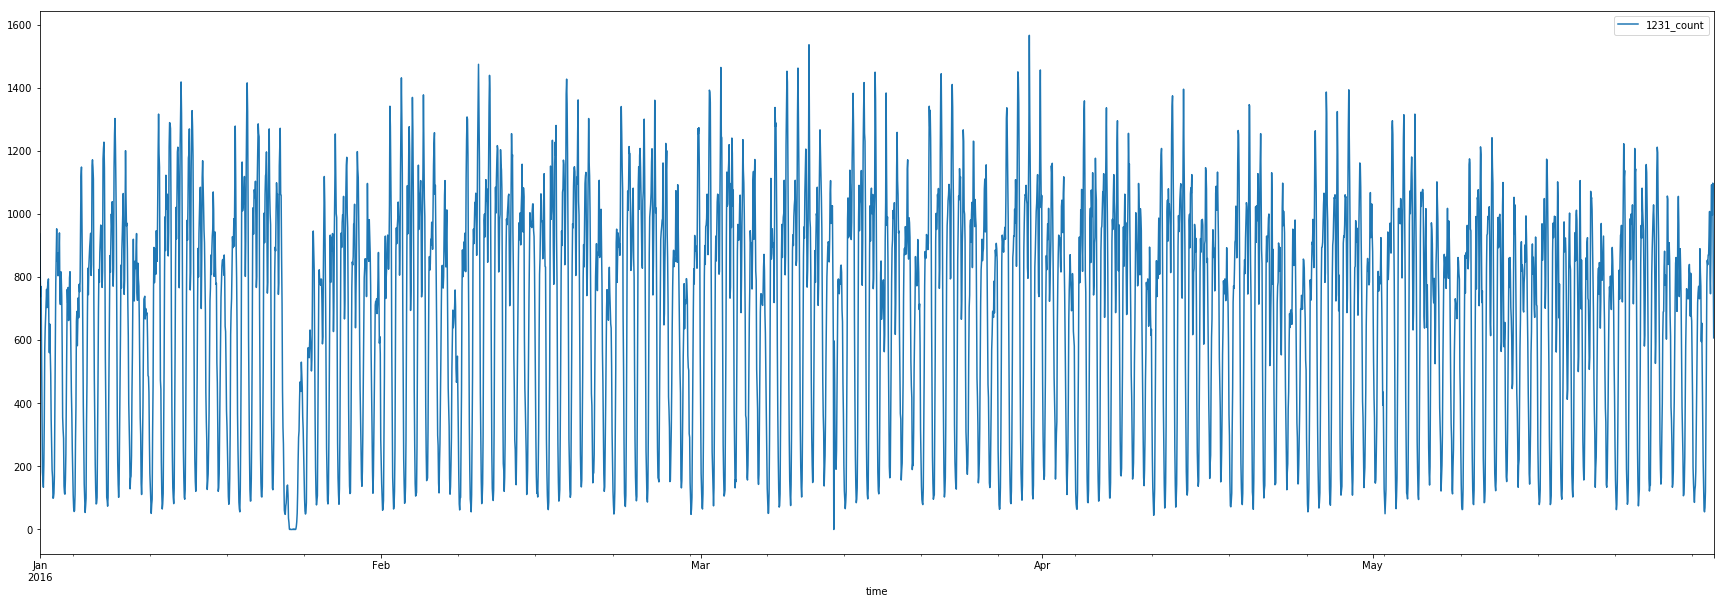

In [48]:
plt.figure(figsize(30,10))
data.plot()

Что ж, график выглядит любопытно. В глаза сразу же бросился факт нулевого числа поездок в конце первого месяца.
Возможно аномалия, может праздник, но скорее всего не работало оборудование.

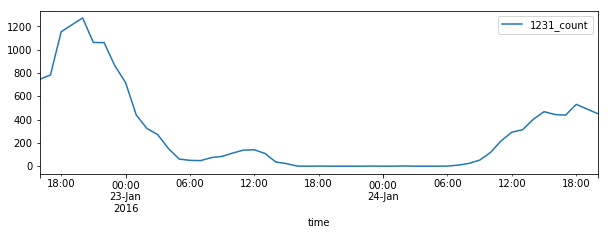

In [49]:
plt.figure(figsize(10,3))
data.ix['22-01-2016 16:00':'24-01-2016 20:00'].plot()

Получилось, что 24 января января с 18 часов вечера до 6 часов утра поездок не было (проверял по другим ячейкам, там ситуация аналогична)

Применим преобразованием Бокса-Кокса

In [50]:
column_cnt = data.columns[0]
data['boxcox'], boxcox_lambda = shifted_boxcox(data[column_cnt])
column_boxcox = data.columns[1]

In [51]:
data.head()

,1231_count,boxcox
time,,
2016-01-01 00:00:00,938.0,618.243874
2016-01-01 01:00:00,830.0,552.568389
2016-01-01 02:00:00,739.0,496.750950
2016-01-01 03:00:00,771.0,516.432767
2016-01-01 04:00:00,560.0,385.426988


Box-Cox lambda: 0.926799


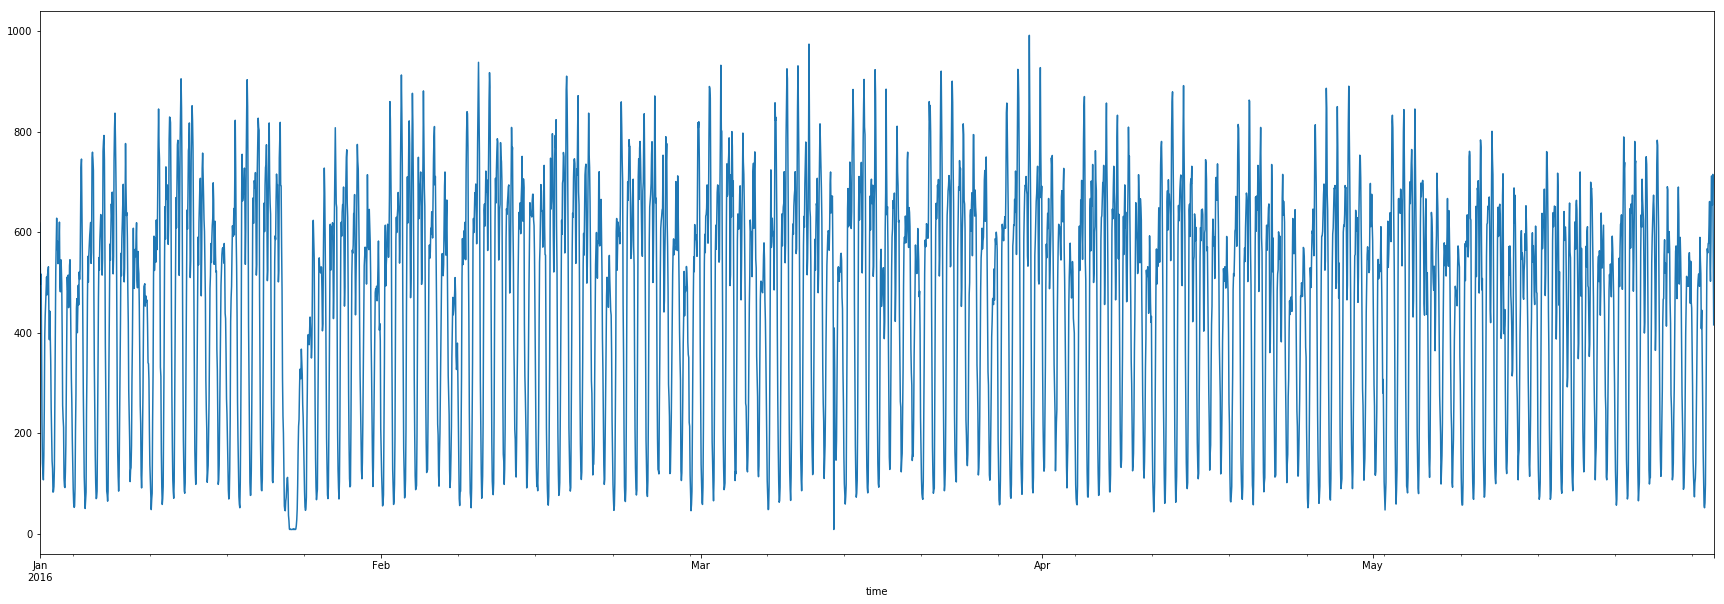

In [52]:
plt.figure(figsize(30,10))
data['boxcox'].plot()
print ("Box-Cox lambda: %f" % boxcox_lambda)

In [53]:
# для отладки
data = data.iloc[:,:2]

Перейдём к созданию регрессионных признаков.
Пробовал руками перебирать K, но это ни к чему не привело

In [54]:
K = 5
for i in range(1, K + 1):
    data['s_%d' % i] = np.fromfunction(lambda x: np.sin((x + 1) * 2 * np.pi * i / 168.0), (len(data),))
    data['c_%d' % i] = np.fromfunction(lambda x: np.cos((x + 1) * 2 * np.pi * i / 168.0), (len(data),))

Ещё можно дабавить в признаки типа дня недели, т.к в начале рабочей недели есть существенные изменения

In [55]:
for dow in range(7):
    data['dow_%d' % dow] = 0
    data.loc[data.index.dayofweek == dow, ['dow_%d' % dow]] = 1

In [56]:
# зафиксируем аномалии, тоже должно помочь
data['anomaly'] = [1 if (x < 565 and x > 530) else 0 for x in range(len(data))]

Построение Линейной регрессии

In [57]:
#1: count, 2: box-cox
lm = linear_model.LinearRegression()
X = data.iloc[:,2:]
y = data[column_boxcox]
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [58]:
# считаем остатки
predictions = lm.predict(X)

resid = pd.DataFrame(index=data.index)
resid['resid'] = y - predictions

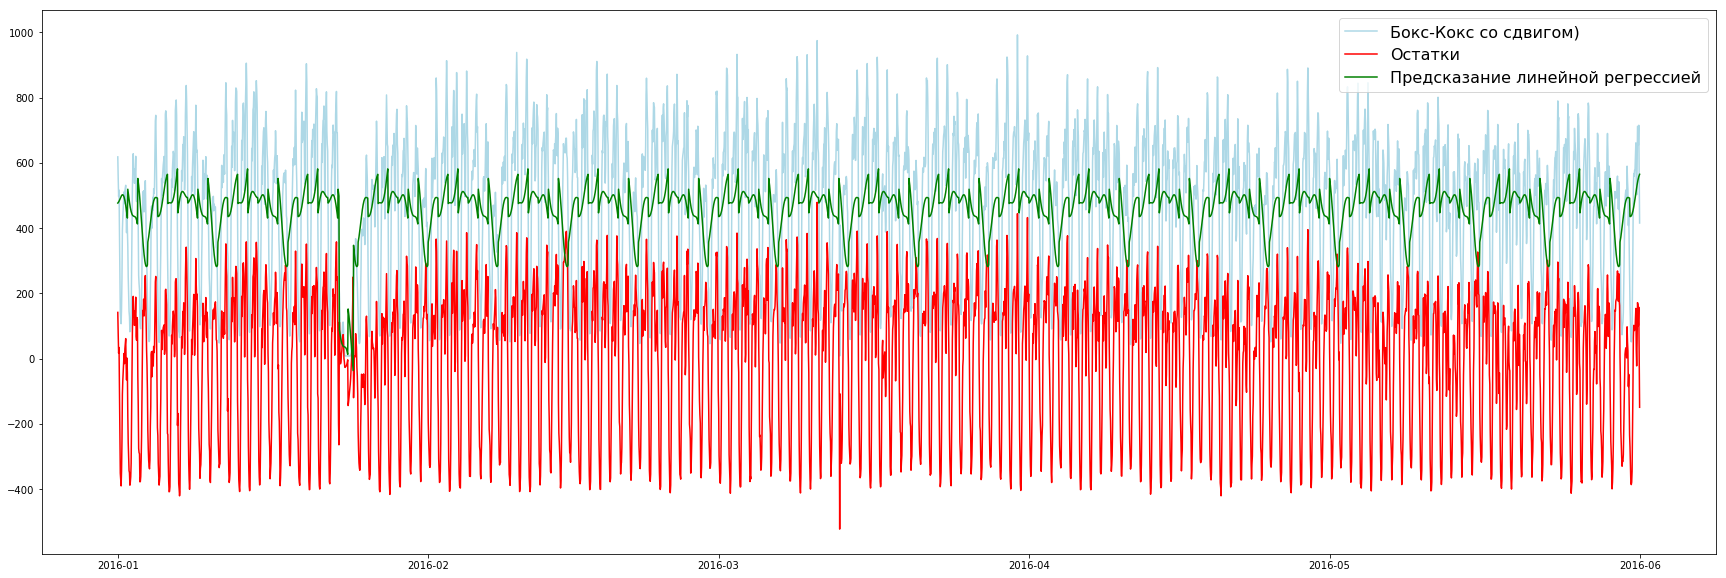

In [59]:
plt.figure(figsize(30,10))

plt.plot(data.index, data[column_boxcox].values, color ='lightblue', label=u'Бокс-Кокс со сдвигом)')
plt.plot(data.index, resid, label=u'Остатки', color='red')
plt.plot(data.index, predictions, label=u'Предсказание линейной регрессией', color='green')
plt.legend(loc=1,prop={'size':16})

Хорошо угадывается аномальное место, но судя по всему, признаков явно не хватает, недельный тренд остаётся

Посмотрим STL декомпозицию остатков

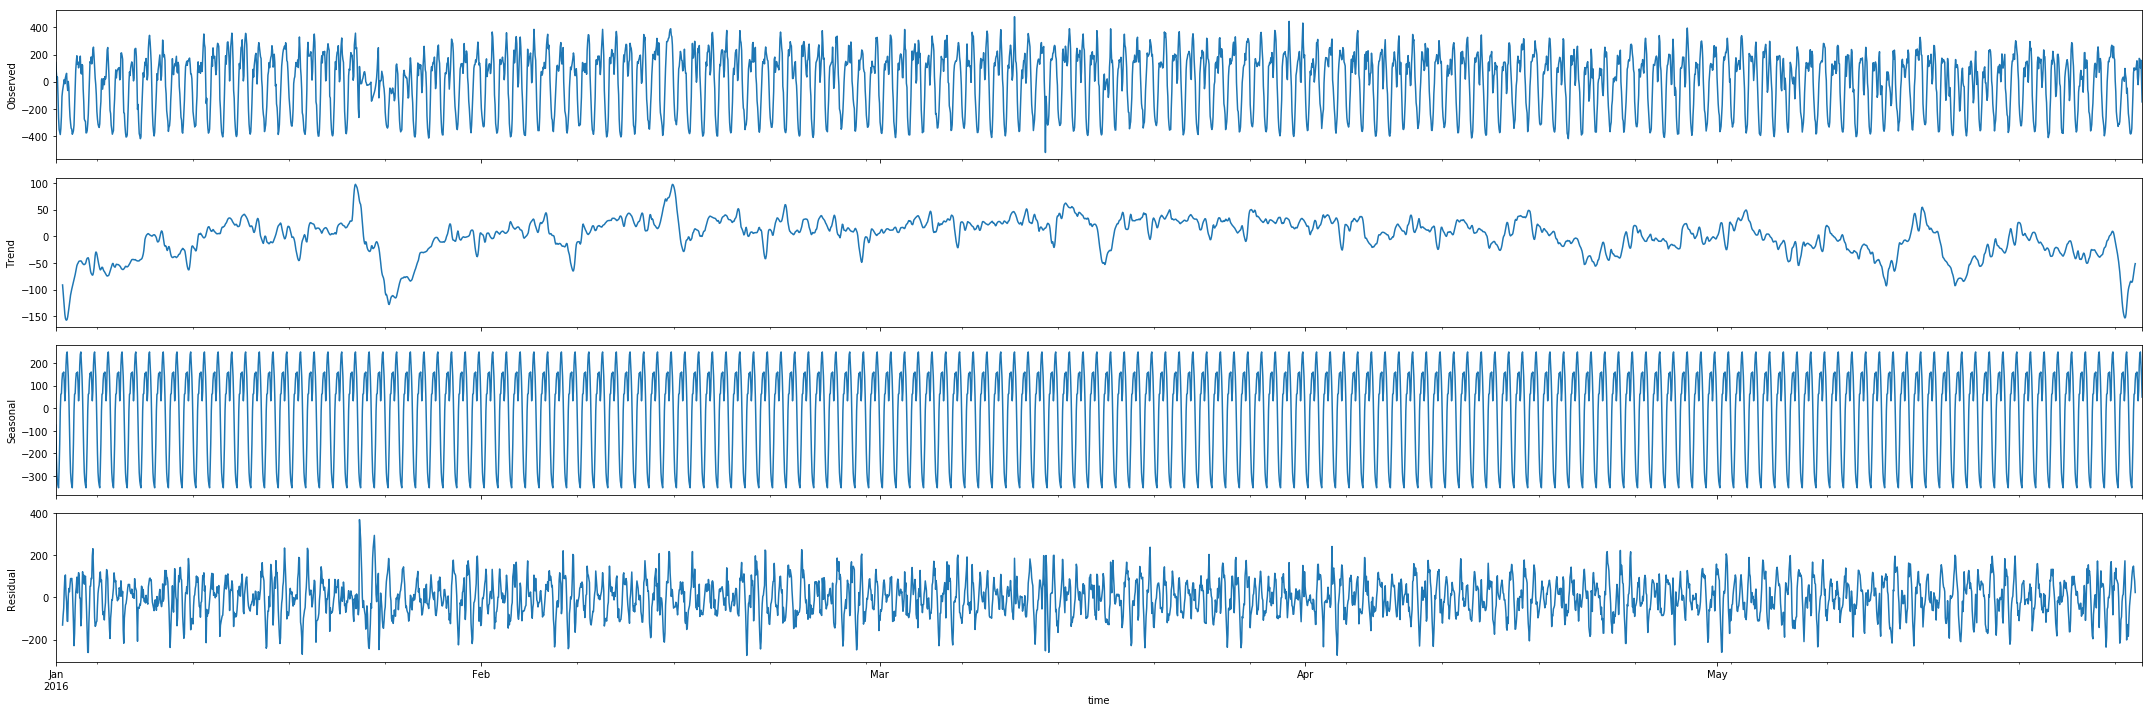

In [60]:
 f =sm.tsa.seasonal_decompose(resid.resid).plot()

In [61]:
# введём дифференцирование на 24 часа и снова посмотрим на STL-декомпозицию.
resid['diff24'] = resid.resid - resid.resid.shift(24)

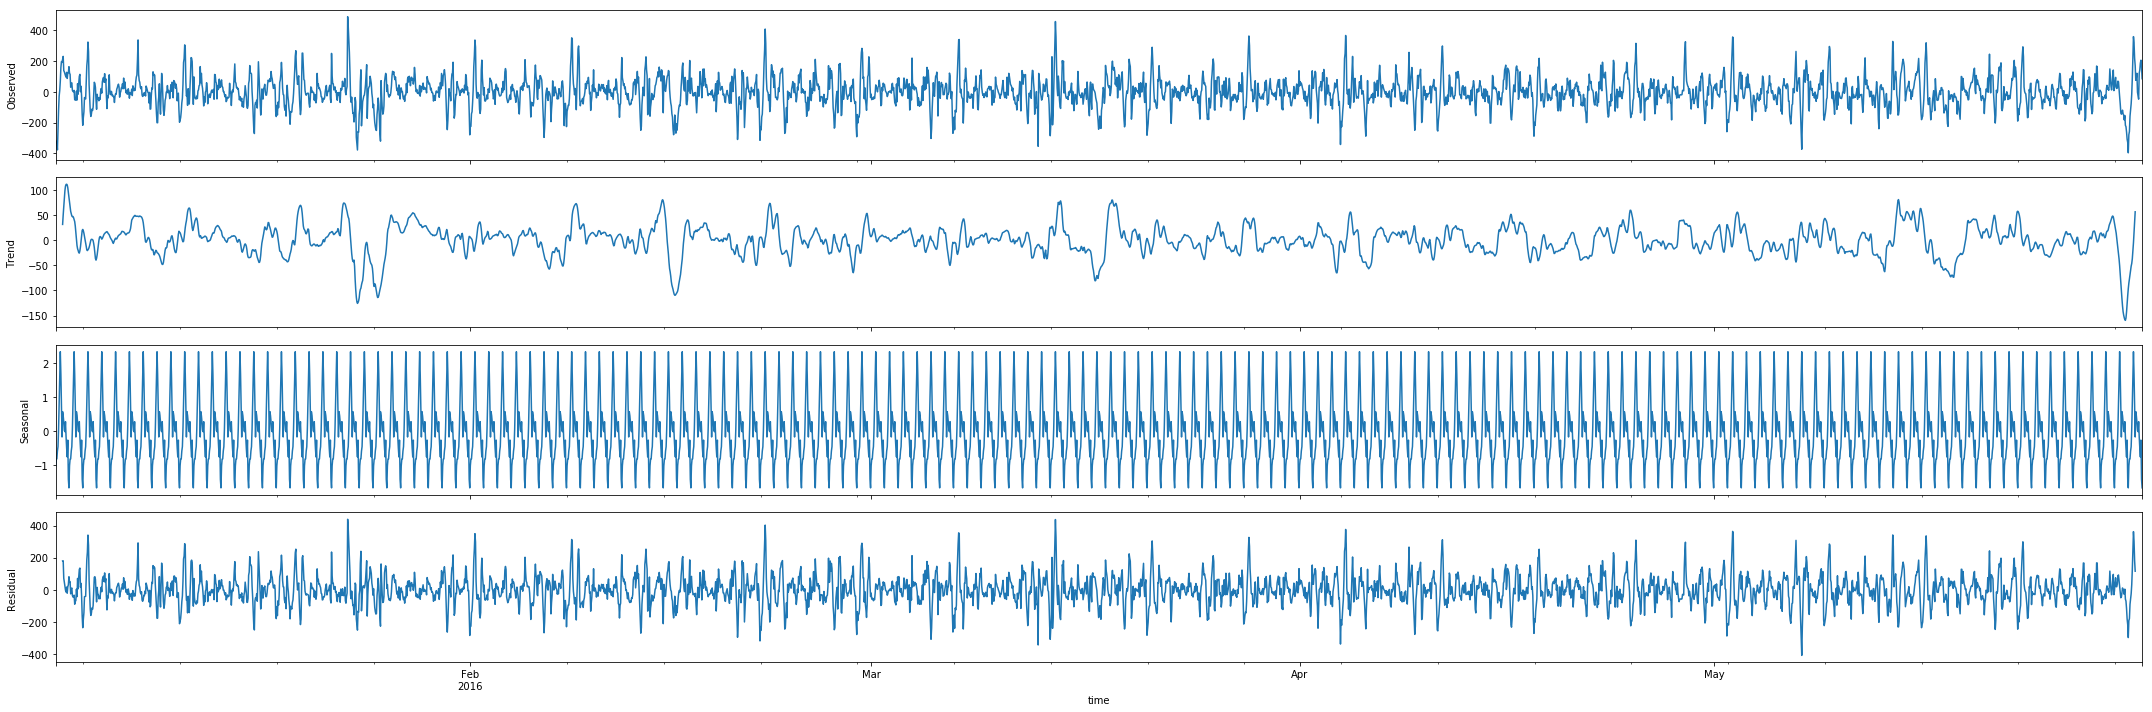

In [62]:
f =sm.tsa.seasonal_decompose(resid['diff24'][24:]).plot()

In [63]:
# Формально проверим гипотезу стационарности, хотя и так было сказано, что он в данном случае не информативен
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(resid.diff24[24:])[1])

Критерий Дики-Фуллера: p=0.000000


Из последних графиков тренд не виден. Перейдём к следущему этапу

## Подбор модели

Посмотрим на ACF и PACF полученного ряда

In [64]:
def plot_acf_pacf(data, start):
    plt.figure(figsize(30,8))
    ax = plt.subplot(211)
    plt1 = sm.graphics.tsa.plot_acf(data[start:].values.squeeze(), lags=168, ax=ax)
    pylab.show()
    ax = plt.subplot(212)
    plt2 = sm.graphics.tsa.plot_pacf(data[start:].values.squeeze(), lags=168, ax=ax)
    pylab.show()

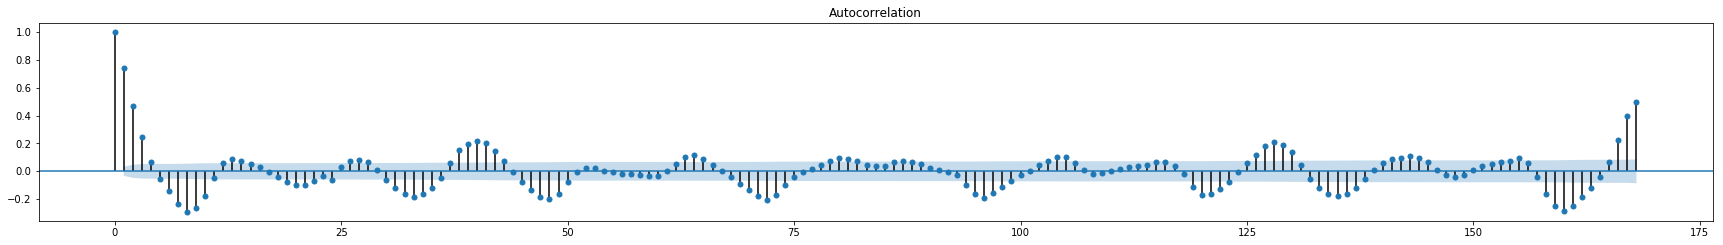

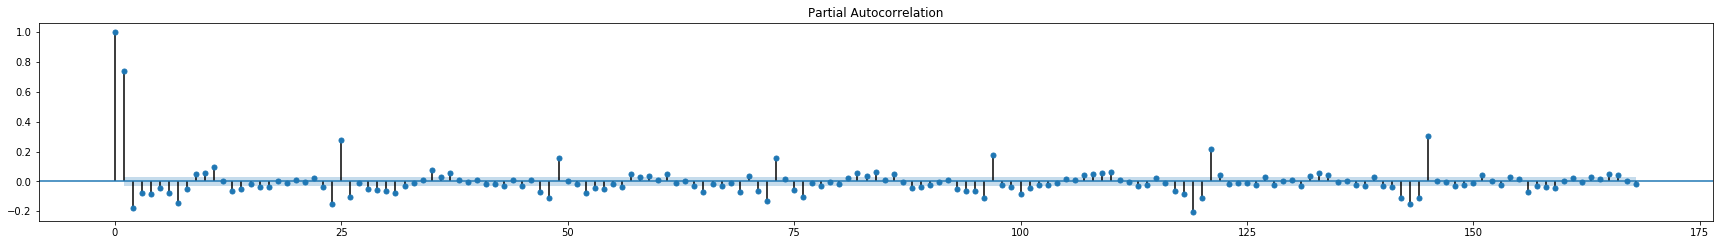

In [65]:
plot_acf_pacf(resid.diff24, 24)

Используя графики, выбираем коэффициенты для SARIMAX: Q=1, q=0, P=2, p=0 (не уверен в их точности)

In [74]:
p=0
d=0
# Параметр q задаётся номером последнего несезонного лага, при котором автокорреляция значима
q=4
P=2
D=1
# номер последнего сезонного лага, при котором автокорреляция значима
Q=0

ps = range(0, p+1)
qs = range(0, q+1)
Ps = range(0, P+1)
Qs = range(0, Q+1)

In [75]:
parameters_list = list(itertools.product(ps, qs, Ps, Qs))
print("Количество комбинаций параметров: %d" % len(parameters_list))

Количество комбинаций параметров: 15


In [76]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(resid.resid,
                                          order=(param[0], d, param[1]), 
                                          seasonal_order=(param[2], D, param[3], 24),
                                         ).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except Exception as e:
        print('wrong parameters:', param)
        print(e)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    print (results[-1])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
could not broadcast input array from shape (0,0) into shape (24,24)
[(0, 0, 1, 0), 43415.800428680006]
[(0, 0, 2, 0), 43252.198842693288]
[(0, 1, 0, 0), 41345.373107158928]
[(0, 1, 1, 0), 41230.162786138928]
[(0, 1, 2, 0), 41120.547597524928]
[(0, 2, 0, 0), nan]
wrong parameters: (0, 2, 1, 0)
array must not contain infs or NaNs
wrong parameters: (0, 2, 2, 0)
array must not contain infs or NaNs
[(0, 3, 0, 0), nan]
wrong parameters: (0, 3, 1, 0)
array must not contain infs or NaNs
wrong parameters: (0, 3, 2, 0)
array must not contain infs or NaNs
[(0, 4, 0, 0), nan]
wrong parameters: (0, 4, 1, 0)
array must not contain infs or NaNs
wrong parameters: (0, 4, 2, 0)
array must not contain infs or NaNs
Wall time: 4min 20s


In [77]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              resid   No. Observations:                 3648
Model:             SARIMAX(0, 0, 1)x(2, 1, 0, 24)   Log Likelihood              -20556.274
Date:                            Wed, 07 Jun 2017   AIC                          41120.548
Time:                                    20:23:02   BIC                          41145.355
Sample:                                01-01-2016   HQIC                         41129.383
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6624      0.010     64.684      0.000       0.642       0.682
ar.S.L24      -0.2137      0.015    -14.158      0.000      -0.243      -0.184
ar.S.L48      -0.1777      0.015    -11.856      0.000      -0.207      -0.148
sigma2      4943.5237     86.710     57.012      0.000    4773.575    5113.473
===================================================================================
Ljung-Box (Q):                     2705.25   Jarque-Bera (JB):               455.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

 построим график модели для Мая, становится грустненько

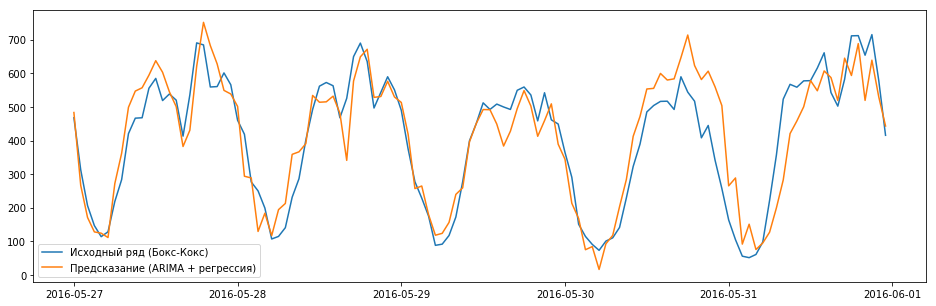

In [78]:
plt.figure(figsize(16,5))
plt.plot(data.boxcox.iloc[-120:], label=u'Исходный ряд (Бокс-Кокс)')
plt.plot(best_model.fittedvalues[-120:] + predictions[-120:], label=u'Предсказание (ARIMA + регрессия)')
plt.legend()
pylab.show()

Посмотрим на остатки модели SARIMAX и их автокорреляцию.

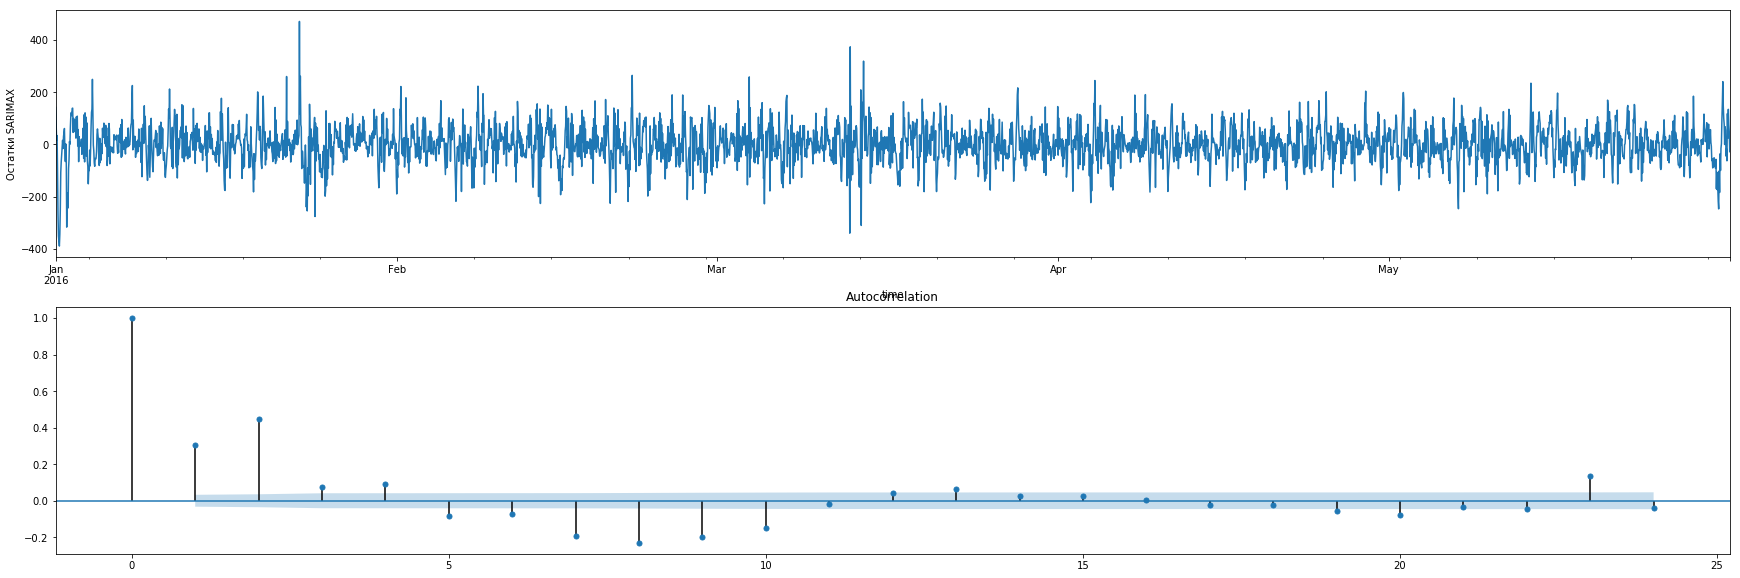

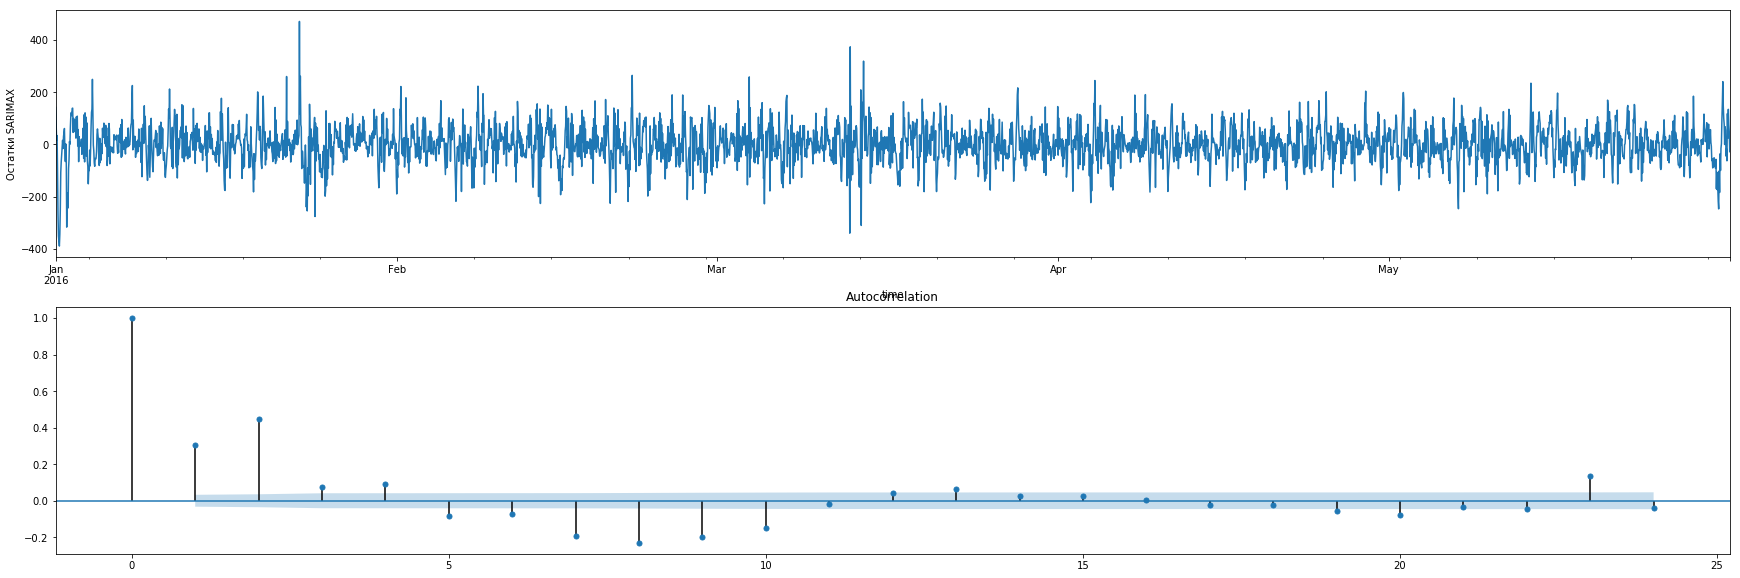

In [79]:
plt.figure(figsize(30,10))
plt.subplot(2,1,1)
best_model.resid.plot()
plt.ylabel(u'Остатки SARIMAX')

ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_acf(best_model.resid[24:].values.squeeze(), lags=24, ax=ax)

In [80]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[24:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[24:])[1])

Критерий Стьюдента: p=0.904899
Критерий Дики-Фуллера: p=0.000000


Остатки несмещены (подтверждается критерием Стьюдента) стационарны (визуально),но похоже автоколлерирован

Осталось вернуть ряд назад(обратное преобразование Бокс-Кокса)

c:\users\dell\anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


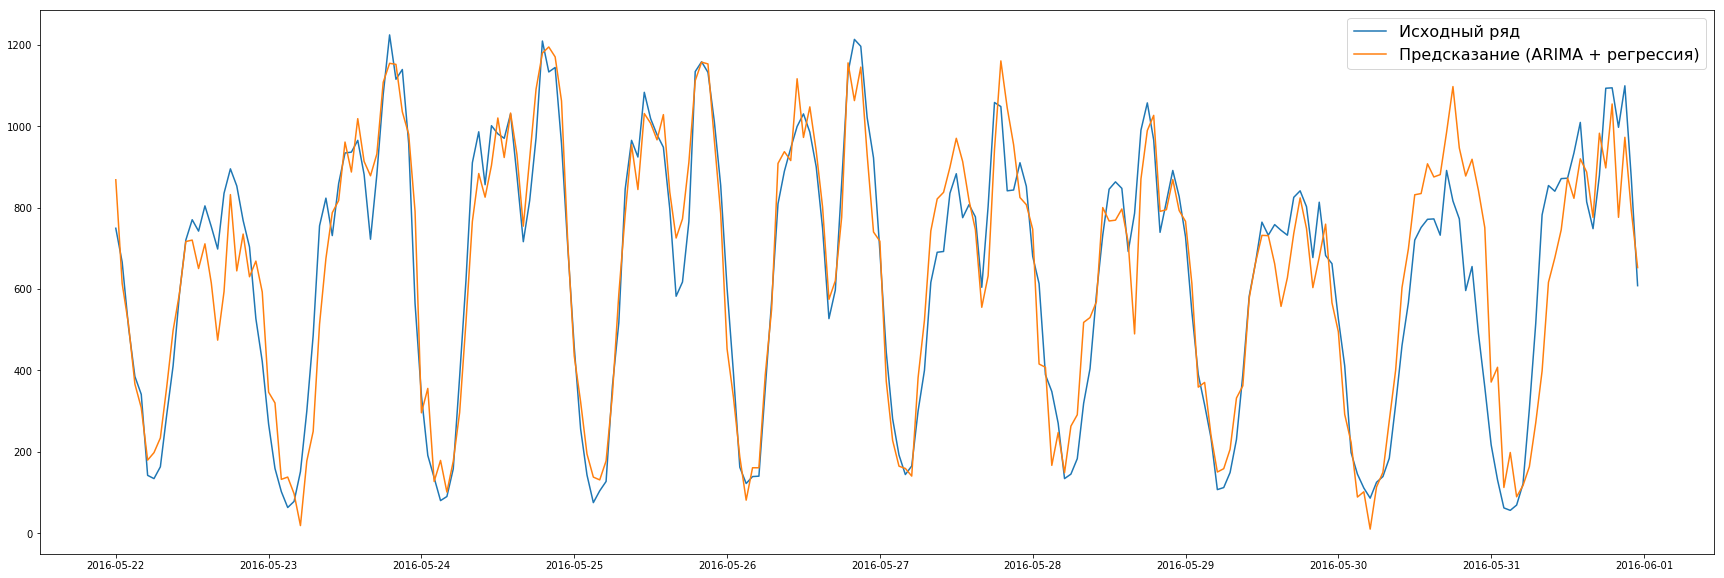

In [83]:
data['prediction'] = inverse_shifted_boxcox(best_model.fittedvalues + predictions, boxcox_lambda)
data.loc[data['prediction'] < 0, ['prediction']] = 0

plt.plot(data[column_cnt].iloc[-240:], label=u'Исходный ряд')
plt.plot(data.prediction[-240:], label=u'Предсказание (ARIMA + регрессия)')
plt.legend(prop={'size':16})

К сожалению, некоторые пики модель не видит. Возможно это можно решить дополнительными признаками.